This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [1]:
#import the dataset
import pandas as pd
data = pd.read_table('data/airfoil_self_noise.dat',header=None, 
                     names= ['freq','angle','chord','stream-velocity',
                             'displacement-thickness','soundpressure'] )

In [2]:
data.head()

,freq,angle,chord,stream-velocity,displacement-thickness,soundpressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
#check the missing values
data.isna().mean()

freq                      0.0
angle                     0.0
chord                     0.0
stream-velocity           0.0
displacement-thickness    0.0
soundpressure             0.0
dtype: float64

In [4]:
#check descriptive stats 
data.describe()

,freq,angle,chord,stream-velocity,displacement-thickness,soundpressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [5]:
#correlation study
data.corr()

,freq,angle,chord,stream-velocity,displacement-thickness,soundpressure
freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
chord,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
stream-velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
displacement-thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
soundpressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [6]:
#extract dependent and independent variables
X = data.drop('soundpressure',axis=1)
y = data.soundpressure

In [7]:
from sklearn.utils import shuffle
X, y = shuffle(X,y,random_state=9)

In [8]:
X.head()

,freq,angle,chord,stream-velocity,displacement-thickness
1086,630,9.5,0.0254,39.6,0.004498
1359,2500,6.7,0.1016,55.5,0.005214
780,3150,4.2,0.0508,71.3,0.001428
1469,3150,12.3,0.1016,31.7,0.041876
1193,4000,17.4,0.0254,39.6,0.017221


In [9]:
y.head()

1086    126.514
1359    124.273
780     133.728
1469    110.307
1193    122.724
Name: soundpressure, dtype: float64

In [10]:
#hyper-parameter tuning on DecisionTree's max-depth
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
scores = []
for i in range(1,15,1):
    model = DecisionTreeRegressor(max_depth=i,random_state=0)
    kfold_score = cross_val_score(model, X, y, cv = 5).mean()
    scores.append(kfold_score)

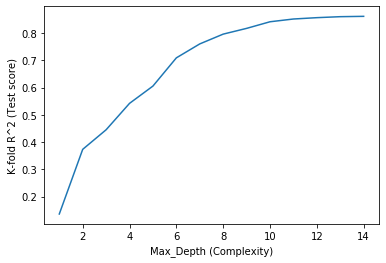

In [11]:
#plot k-fold scores vs max_depth values
import matplotlib.pyplot as plt
plt.plot(range(1,15,1),scores)
plt.xlabel('Max_Depth (Complexity)')
plt.ylabel('K-fold R^2 (Test score)')
plt.show()

From the figure above, max-depth of 10 would be better trade off

In [12]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

[Text(167.4, 181.2, 'freq <= 3575.0\nmse = 47.56\nsamples = 1503\nvalue = 124.836'),
 Text(83.7, 108.72, 'displacement-thickness <= 0.016\nmse = 32.08\nsamples = 1079\nvalue = 126.57'),
 Text(41.85, 36.23999999999998, '\n  (...)  \n'),
 Text(125.55000000000001, 36.23999999999998, '\n  (...)  \n'),
 Text(251.10000000000002, 108.72, 'displacement-thickness <= 0.002\nmse = 59.842\nsamples = 424\nvalue = 120.424'),
 Text(209.25, 36.23999999999998, '\n  (...)  \n'),
 Text(292.95, 36.23999999999998, '\n  (...)  \n')]

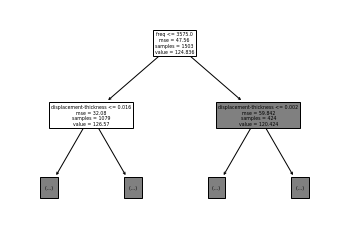

In [13]:
from sklearn.tree import plot_tree
plot_tree(model,feature_names=X.columns,max_depth=1)

Looking at the first two splits and the correlation study, we can see that two of the strongest correlated features with the target variable  appear in the splitting nodes. This also leads us to believe that there is a strong connection between the two approaches of modelling. Infact, another form of Decision Trees exist that base their splitting decision on correlation (*Chi-square automatic interaction detection (CHAID) is a decision tree technique, based on adjusted significance testing*) 

In [14]:
cross_val_score(DecisionTreeRegressor(max_depth=10),X,y,cv=5).mean()

0.8419758935492532

The k-fold score slightly improves as compared to that of Linear Regression model but there could be room for improvement still. May be we will find out in the next section!!

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [16]:
#Graph k-fold score vs no. of estimators in Random Forest
scores = []
for i in range(10,101,10):
    scores.append(cross_val_score(RandomForestRegressor(n_estimators=i,random_state=9),
                                  X,y,cv=4).mean())

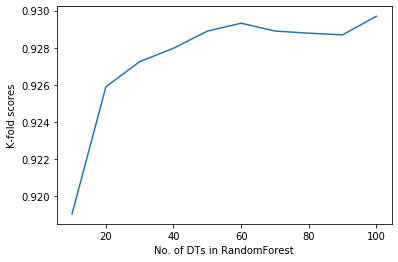

In [17]:
plt.plot(range(10,101,10),scores)
plt.xlabel('No. of DTs in RandomForest')
plt.ylabel('K-fold scores')
plt.show()

In [39]:
params = {
            'n_estimators': [100,110,120,130],
            'max_depth': [13,14,15]
        }
model = GridSearchCV(RandomForestRegressor(), params,cv=4)
model.fit(X,y)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [40]:
model.best_params_

{'max_depth': 14, 'n_estimators': 110}

In [41]:
model.best_score_

0.9308876771628191

In [42]:
best_model = model.best_estimator_

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=5)

In [44]:
best_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [45]:
best_model.score(X_test,y_test)

0.9196676691293985

In [46]:
cross_val_score(RandomForestRegressor(n_estimators=110,max_depth=14),X,y,cv=4)

array([0.93702785, 0.92016072, 0.9370746 , 0.92662528])